In [ ]:
import os, textwrap, pathlib, json

OUT_DIR = "/content/rl_car_game_web"
os.makedirs(OUT_DIR, exist_ok=True)

index_html = r"""<!doctype html>
<html lang="en">
<head>
  <meta charset="utf-8" />
  <meta name="viewport" content="width=device-width,initial-scale=1,maximum-scale=1,user-scalable=no" />
  <title>Lane Car (Manual)</title>
  <style>
    html, body { height: 100%; margin: 0; background:#0b0f14; font-family: system-ui, -apple-system, Segoe UI, Roboto, Arial; color:#dbe7ff; }
    .wrap { display:flex; flex-direction:column; height:100%; }
    header { padding: 10px 12px; display:flex; gap:12px; align-items:center; justify-content:space-between; }
    .pill { font-size:12px; opacity:.9; padding:6px 10px; border:1px solid #24324a; border-radius:999px; background:#0f1622; }
    #gameArea { position:relative; flex:1; display:flex; align-items:center; justify-content:center; }
    canvas { width: min(96vw, 520px); height: calc(min(96vw, 520px) * 1.6); max-height: 82vh; border-radius: 14px; background:#111827; box-shadow: 0 10px 30px rgba(0,0,0,.4); touch-action:none; }
    .hud { position:absolute; top:14px; left:50%; transform:translateX(-50%); display:flex; gap:8px; }
    .btnBar { position:absolute; bottom:16px; left:50%; transform:translateX(-50%); display:flex; gap:12px; align-items:center; }
    .btn {
      width:64px; height:64px; border-radius:16px;
      border:1px solid #2a3a55; background:#0f172a; color:#dbe7ff;
      font-size:22px; font-weight:700;
      display:flex; align-items:center; justify-content:center;
      user-select:none;
    }
    .btn:active { transform: translateY(1px); filter:brightness(1.2); }
    .small { width:auto; padding:0 14px; font-size:14px; height:46px; border-radius:14px; }
    .hint { opacity:.75; font-size:12px; }
  </style>
</head>
<body>
  <div class="wrap">
    <header>
      <div class="pill">Controls: ← → or A/D • Mobile: touch buttons</div>
      <div class="pill" id="modePill">Mode: MANUAL</div>
    </header>

    <div id="gameArea">
      <canvas id="c"></canvas>

      <div class="hud">
        <div class="pill">Score: <span id="score">0</span></div>
        <div class="pill">Best: <span id="best">0</span></div>
        <div class="pill">Speed: <span id="speed">1.0</span>x</div>
      </div>

      <div class="btnBar">
        <div class="btn" id="leftBtn">◀</div>
        <div class="btn small" id="restartBtn">Restart</div>
        <div class="btn" id="rightBtn">▶</div>
      </div>
    </div>

    <header>
      <div class="hint">Goal: stay on the road and avoid blocks. This is the base game; RL comes next.</div>
      <div class="pill">v0.1</div>
    </header>

  </div>

  <script src="game.js"></script>
</body>
</html>
"""

game_js = r"""(() => {
  const canvas = document.getElementById("c");
  const ctx = canvas.getContext("2d");

  // --- Responsive internal resolution (keeps crispness) ---
  function resize() {
    const cssW = canvas.clientWidth;
    const cssH = canvas.clientHeight;
    const dpr = Math.max(1, Math.min(2, window.devicePixelRatio || 1));
    canvas.width = Math.floor(cssW * dpr);
    canvas.height = Math.floor(cssH * dpr);
  }
  window.addEventListener("resize", resize);

  // --- UI ---
  const scoreEl = document.getElementById("score");
  const bestEl  = document.getElementById("best");
  const speedEl = document.getElementById("speed");
  const restartBtn = document.getElementById("restartBtn");
  const leftBtn = document.getElementById("leftBtn");
  const rightBtn = document.getElementById("rightBtn");

  // --- Game state ---
  let best = Number(localStorage.getItem("best_lane_car") || 0);
  bestEl.textContent = best;

  const lanes = 3;
  const roadMargin = 0.18; // % of width on both sides outside road
  let keyLeft = false, keyRight = false;

  function clamp(v, a, b) { return Math.max(a, Math.min(b, v)); }

  function reset() {
    resize();
    t = 0;
    score = 0;
    speed = 1.0;
    alive = true;

    // Player position is lane index (0..lanes-1), plus smooth x
    playerLane = 1;
    playerX = 0; // normalized [-1..1] around road center
    targetLane = playerLane;

    obstacles.length = 0;
    spawnTimer = 0;
    scoreEl.textContent = "0";
    speedEl.textContent = speed.toFixed(1);
  }

  let t = 0;
  let score = 0;
  let speed = 1.0;
  let alive = true;

  let playerLane = 1;
  let targetLane = 1;

  // normalized x (road coordinates)
  let playerX = 0;
  const obstacles = [];
  let spawnTimer = 0;

  function roadRect() {
    const W = canvas.width, H = canvas.height;
    const left = W * roadMargin;
    const right = W * (1 - roadMargin);
    return { left, right, top: 0, bottom: H, width: right - left, height: H };
  }

  function laneCenterX(laneIdx) {
    const rr = roadRect();
    const laneW = rr.width / lanes;
    return rr.left + laneW * (laneIdx + 0.5);
  }

  function spawnObstacle() {
    // choose random lane
    const lane = Math.floor(Math.random() * lanes);
    const rr = roadRect();
    const w = rr.width / lanes * 0.55;
    const h = rr.height * 0.06;
    const x = laneCenterX(lane);
    const y = -h;
    obstacles.push({ lane, x, y, w, h });
  }

  function setLane(delta) {
    if (!alive) return;
    targetLane = clamp(targetLane + delta, 0, lanes - 1);
  }

  // Keyboard
  window.addEventListener("keydown", (e) => {
    if (e.key === "ArrowLeft" || e.key.toLowerCase() === "a") keyLeft = true;
    if (e.key === "ArrowRight" || e.key.toLowerCase() === "d") keyRight = true;
    if (e.key.toLowerCase() === "r") reset();
  });
  window.addEventListener("keyup", (e) => {
    if (e.key === "ArrowLeft" || e.key.toLowerCase() === "a") keyLeft = false;
    if (e.key === "ArrowRight" || e.key.toLowerCase() === "d") keyRight = false;
  });

  // Touch buttons (pointer events)
  function bindHold(btn, onDown, onUp) {
    btn.addEventListener("pointerdown", (e) => { e.preventDefault(); btn.setPointerCapture(e.pointerId); onDown(); });
    btn.addEventListener("pointerup", (e) => { e.preventDefault(); onUp(); });
    btn.addEventListener("pointercancel", (e) => { e.preventDefault(); onUp(); });
    btn.addEventListener("pointerleave", (e) => { /* ignore */ });
  }
  bindHold(leftBtn,  () => (keyLeft = true),  () => (keyLeft = false));
  bindHold(rightBtn, () => (keyRight = true), () => (keyRight = false));

  restartBtn.addEventListener("click", reset);

  // --- Main loop ---
  let last = performance.now();
  function loop(now) {
    const dt = Math.min(0.033, (now - last) / 1000);
    last = now;
    update(dt);
    render();
    requestAnimationFrame(loop);
  }

  function update(dt) {
    t += dt;

    // Speed ramps slowly with score
    speed = 1.0 + Math.min(2.2, score / 2500);
    speedEl.textContent = speed.toFixed(1);

    if (!alive) return;

    // Input -> target lane
    if (keyLeft) setLane(-1), keyLeft = false; // tap-like (one lane per press/hold tick)
    if (keyRight) setLane(+1), keyRight = false;

    // Smooth move playerX toward target lane center
    const W = canvas.width;
    const rr = roadRect();
    const targetX = laneCenterX(targetLane);
    const curX = rr.left + rr.width/2 + playerX * (rr.width/2);
    const lerp = 1 - Math.pow(0.001, dt * 8); // smooth
    const newX = curX + (targetX - curX) * lerp;

    // convert back to normalized playerX
    playerX = ((newX - (rr.left + rr.width/2)) / (rr.width/2));
    playerX = clamp(playerX, -0.95, 0.95);

    // Spawn obstacles
    spawnTimer -= dt * speed;
    if (spawnTimer <= 0) {
      spawnObstacle();
      // harder over time
      const base = 0.65;
      const minT = 0.25;
      spawnTimer = Math.max(minT, base - score / 6000);
    }

    // Move obstacles downward
    const fall = rr.height * (0.55 * speed);
    for (const ob of obstacles) ob.y += fall * dt;

    // Remove passed obstacles + add score
    for (let i = obstacles.length - 1; i >= 0; i--) {
      if (obstacles[i].y > rr.height + obstacles[i].h) {
        obstacles.splice(i, 1);
        score += 25;
        scoreEl.textContent = String(score);
      }
    }

    // Collision
    const p = playerRect();
    for (const ob of obstacles) {
      const r = { x: ob.x - ob.w/2, y: ob.y - ob.h/2, w: ob.w, h: ob.h };
      if (rectOverlap(p, r)) {
        alive = false;
        best = Math.max(best, score);
        localStorage.setItem("best_lane_car", String(best));
        bestEl.textContent = best;
        break;
      }
    }
  }

  function playerRect() {
    const rr = roadRect();
    const carW = rr.width / lanes * 0.55;
    const carH = rr.height * 0.07;
    const x = rr.left + rr.width/2 + playerX * (rr.width/2);
    const y = rr.height * 0.84;
    return { x: x - carW/2, y: y - carH/2, w: carW, h: carH };
  }

  function rectOverlap(a, b) {
    return (a.x < b.x + b.w && a.x + a.w > b.x && a.y < b.y + b.h && a.y + a.h > b.y);
  }

  function render() {
    const W = canvas.width, H = canvas.height;
    ctx.clearRect(0, 0, W, H);

    const rr = roadRect();

    // Background
    ctx.fillStyle = "#0b0f14";
    ctx.fillRect(0, 0, W, H);

    // Road
    ctx.fillStyle = "#111827";
    ctx.fillRect(rr.left, 0, rr.width, rr.height);

    // Lane lines
    ctx.strokeStyle = "rgba(219,231,255,0.18)";
    ctx.lineWidth = Math.max(2, W * 0.004);
    for (let i = 1; i < lanes; i++) {
      const x = rr.left + (rr.width / lanes) * i;
      dashedLine(x, 0, x, H);
    }

    // Borders
    ctx.strokeStyle = "rgba(219,231,255,0.35)";
    ctx.lineWidth = Math.max(2, W * 0.006);
    ctx.beginPath();
    ctx.moveTo(rr.left, 0); ctx.lineTo(rr.left, H);
    ctx.moveTo(rr.right, 0); ctx.lineTo(rr.right, H);
    ctx.stroke();

    // Obstacles
    for (const ob of obstacles) {
      const x = ob.x - ob.w/2, y = ob.y - ob.h/2;
      roundRect(x, y, ob.w, ob.h, Math.max(8, ob.h * 0.3), "#ef4444");
    }

    // Player car
    const p = playerRect();
    roundRect(p.x, p.y, p.w, p.h, Math.max(10, p.h * 0.35), alive ? "#22c55e" : "#94a3b8");

    // Game over text
    if (!alive) {
      ctx.fillStyle = "rgba(0,0,0,0.55)";
      ctx.fillRect(0, 0, W, H);
      ctx.fillStyle = "#dbe7ff";
      ctx.textAlign = "center";
      ctx.font = `bold ${Math.floor(W * 0.06)}px system-ui`;
      ctx.fillText("Game Over", W/2, H*0.42);
      ctx.font = `${Math.floor(W * 0.038)}px system-ui`;
      ctx.fillText("Press R or tap Restart", W/2, H*0.49);
    }
  }

  function dashedLine(x1, y1, x2, y2) {
    const dash = Math.max(14, canvas.height * 0.03);
    const gap  = dash * 0.8;
    let y = 0;
    while (y < canvas.height) {
      ctx.beginPath();
      ctx.moveTo(x1, y);
      ctx.lineTo(x2, Math.min(canvas.height, y + dash));
      ctx.stroke();
      y += dash + gap;
    }
  }

  function roundRect(x, y, w, h, r, fillStyle) {
    r = Math.min(r, w/2, h/2);
    ctx.fillStyle = fillStyle;
    ctx.beginPath();
    ctx.moveTo(x + r, y);
    ctx.arcTo(x + w, y, x + w, y + h, r);
    ctx.arcTo(x + w, y + h, x, y + h, r);
    ctx.arcTo(x, y + h, x, y, r);
    ctx.arcTo(x, y, x + w, y, r);
    ctx.closePath();
    ctx.fill();
  }

  reset();
  requestAnimationFrame(loop);
})();
"""

pathlib.Path(f"{OUT_DIR}/index.html").write_text(index_html, encoding="utf-8")
pathlib.Path(f"{OUT_DIR}/game.js").write_text(game_js, encoding="utf-8")

print("Wrote:", OUT_DIR)
print("Files:", os.listdir(OUT_DIR))


Wrote: /content/rl_car_game_web
Files: ['game.js', 'index.html']


In [ ]:
import os, socket, threading, http.server, socketserver
from google.colab import output

OUT_DIR = "/content/rl_car_game_web"

def run_server(directory, port):
  os.chdir(directory)
  handler = http.server.SimpleHTTPRequestHandler
  with socketserver.TCPServer(("0.0.0.0", port), handler) as httpd:
    httpd.serve_forever()

# find a free port
sock = socket.socket()
sock.bind(("", 0))
port = sock.getsockname()[1]
sock.close()

threading.Thread(target=run_server, args=(OUT_DIR, port), daemon=True).start()
print("Server port:", port)

# open via Colab's proxy (works, unlike 127.0.0.1 iframe)
output.serve_kernel_port_as_window(port)


Server port: 42129
Try `serve_kernel_port_as_iframe` instead. 


<IPython.core.display.Javascript object>

In [ ]:
import pathlib, json, os, textwrap

OUT_DIR = "/content/rl_car_game_web"

# --- 1) Update index.html: add an AI toggle button in the header ---
index_path = pathlib.Path(f"{OUT_DIR}/index.html")
html = index_path.read_text(encoding="utf-8")

# Replace the right-side pill with a real button we can click
html = html.replace(
  '<div class="pill" id="modePill">Mode: MANUAL</div>',
  '<button class="pill" id="modeBtn" style="cursor:pointer;">Mode: MANUAL</button>'
)

index_path.write_text(html, encoding="utf-8")
print("Updated index.html")


# --- 2) Replace game.js with AI/MANUAL toggle + policy hook (loads policy.json if present) ---
game_js = r"""(() => {
  const canvas = document.getElementById("c");
  const ctx = canvas.getContext("2d");

  function resize() {
    const cssW = canvas.clientWidth;
    const cssH = canvas.clientHeight;
    const dpr = Math.max(1, Math.min(2, window.devicePixelRatio || 1));
    canvas.width = Math.floor(cssW * dpr);
    canvas.height = Math.floor(cssH * dpr);
  }
  window.addEventListener("resize", resize);

  const scoreEl = document.getElementById("score");
  const bestEl  = document.getElementById("best");
  const speedEl = document.getElementById("speed");
  const restartBtn = document.getElementById("restartBtn");
  const leftBtn = document.getElementById("leftBtn");
  const rightBtn = document.getElementById("rightBtn");
  const modeBtn = document.getElementById("modeBtn"); // NEW

  let best = Number(localStorage.getItem("best_lane_car") || 0);
  bestEl.textContent = best;

  const lanes = 3;
  const roadMargin = 0.18;
  let keyLeft = false, keyRight = false;

  function clamp(v, a, b) { return Math.max(a, Math.min(b, v)); }

  // -------------------- AI TOGGLE + POLICY HOOK (NEW) --------------------
  let mode = "MANUAL"; // or "AI"
  function setMode(next) {
    mode = next;
    modeBtn.textContent = `Mode: ${mode}`;
  }
  modeBtn.addEventListener("click", () => setMode(mode === "MANUAL" ? "AI" : "MANUAL"));
  setMode("MANUAL");

  // Policy params loaded from policy.json later (after training)
  // We'll support a simple linear policy: action = argmax(W*state + b) over 3 actions [-1,0,+1]
  // If policy isn't loaded yet, we use a tiny heuristic as fallback.
  let policy = null; // {W: [[...],[...],[...]], b:[...], state_dim:int}

  async function loadPolicy() {
    try {
      const res = await fetch("policy.json", { cache: "no-store" });
      if (!res.ok) throw new Error("policy.json not found");
      const p = await res.json();
      if (!p || !p.W || !p.b) throw new Error("bad policy.json");
      policy = p;
      console.log("Loaded policy.json", policy);
    } catch (e) {
      policy = null;
      console.log("No policy.json yet (ok).", e.message);
    }
  }
  loadPolicy();

  function argmax(arr) {
    let bi = 0, bv = arr[0];
    for (let i=1;i<arr.length;i++) if (arr[i] > bv) { bv = arr[i]; bi = i; }
    return bi;
  }

  // State: [lane_idx (0..2), next_ob_lane (0..2), next_ob_dist_norm (0..1), speed_norm (0..1)]
  function getState() {
    const rr = roadRect();
    const playerLaneIdx = targetLane;

    // find nearest obstacle in front of player (smallest positive dy)
    let bestOb = null;
    const py = rr.height * 0.84;
    for (const ob of obstacles) {
      const dy = (py - ob.y); // positive means obstacle is above player (approaching)
      if (dy >= 0) {
        if (!bestOb || dy < bestOb.dy) bestOb = { dy, lane: ob.lane };
      }
    }

    const nextLane = bestOb ? bestOb.lane : playerLaneIdx;
    const dist = bestOb ? clamp(bestOb.dy / rr.height, 0, 1) : 1.0;

    const speedNorm = clamp((speed - 1.0) / 2.2, 0, 1);

    return [playerLaneIdx, nextLane, dist, speedNorm];
  }

  // action: -1, 0, +1
  function policyAction(state) {
    if (policy && policy.W && policy.b) {
      const W = policy.W; // 3 x D
      const b = policy.b; // 3
      const logits = [0,0,0];
      for (let a=0;a<3;a++){
        let s = b[a] || 0;
        for (let j=0;j<state.length;j++) s += (W[a][j] || 0) * state[j];
        logits[a] = s;
      }
      const idx = argmax(logits); // 0,1,2
      return idx === 0 ? -1 : (idx === 1 ? 0 : +1);
    }

    // Fallback heuristic (until we train): steer away if next obstacle is in same lane and close
    const [laneIdx, nextLane, dist] = state;
    if (nextLane === laneIdx && dist < 0.35) {
      if (laneIdx === 0) return +1;
      if (laneIdx === 2) return -1;
      // middle -> pick the side that looks freer (random for now)
      return Math.random() < 0.5 ? -1 : +1;
    }
    return 0;
  }
  // ----------------------------------------------------------------------

  function reset() {
    resize();
    t = 0;
    score = 0;
    speed = 1.0;
    alive = true;

    playerLane = 1;
    playerX = 0;
    targetLane = playerLane;

    obstacles.length = 0;
    spawnTimer = 0;
    scoreEl.textContent = "0";
    speedEl.textContent = speed.toFixed(1);
  }

  let t = 0;
  let score = 0;
  let speed = 1.0;
  let alive = true;

  let playerLane = 1;
  let targetLane = 1;

  let playerX = 0;
  const obstacles = [];
  let spawnTimer = 0;

  function roadRect() {
    const W = canvas.width, H = canvas.height;
    const left = W * roadMargin;
    const right = W * (1 - roadMargin);
    return { left, right, top: 0, bottom: H, width: right - left, height: H };
  }

  function laneCenterX(laneIdx) {
    const rr = roadRect();
    const laneW = rr.width / lanes;
    return rr.left + laneW * (laneIdx + 0.5);
  }

  function spawnObstacle() {
    const lane = Math.floor(Math.random() * lanes);
    const rr = roadRect();
    const w = rr.width / lanes * 0.55;
    const h = rr.height * 0.06;
    const x = laneCenterX(lane);
    const y = -h;
    obstacles.push({ lane, x, y, w, h });
  }

  function setLane(delta) {
    if (!alive) return;
    targetLane = clamp(targetLane + delta, 0, lanes - 1);
  }

  // Keyboard
  window.addEventListener("keydown", (e) => {
    if (e.key === "ArrowLeft" || e.key.toLowerCase() === "a") keyLeft = true;
    if (e.key === "ArrowRight" || e.key.toLowerCase() === "d") keyRight = true;
    if (e.key.toLowerCase() === "r") reset();
    if (e.key.toLowerCase() === "m") setMode(mode === "MANUAL" ? "AI" : "MANUAL"); // NEW hotkey
  });
  window.addEventListener("keyup", (e) => {
    if (e.key === "ArrowLeft" || e.key.toLowerCase() === "a") keyLeft = false;
    if (e.key === "ArrowRight" || e.key.toLowerCase() === "d") keyRight = false;
  });

  // Touch buttons
  function bindHold(btn, onDown, onUp) {
    btn.addEventListener("pointerdown", (e) => { e.preventDefault(); btn.setPointerCapture(e.pointerId); onDown(); });
    btn.addEventListener("pointerup", (e) => { e.preventDefault(); onUp(); });
    btn.addEventListener("pointercancel", (e) => { e.preventDefault(); onUp(); });
  }
  bindHold(leftBtn,  () => (keyLeft = true),  () => (keyLeft = false));
  bindHold(rightBtn, () => (keyRight = true), () => (keyRight = false));

  restartBtn.addEventListener("click", reset);

  let last = performance.now();
  function loop(now) {
    const dt = Math.min(0.033, (now - last) / 1000);
    last = now;
    update(dt);
    render();
    requestAnimationFrame(loop);
  }

  function update(dt) {
    t += dt;

    speed = 1.0 + Math.min(2.2, score / 2500);
    speedEl.textContent = speed.toFixed(1);

    if (!alive) return;

    // -------------------- AI CONTROL (NEW) --------------------
    if (mode === "AI") {
      const state = getState();
      const act = policyAction(state); // -1,0,+1
      if (act !== 0) setLane(act);
    } else {
      // Manual input -> target lane
      if (keyLeft) setLane(-1), keyLeft = false;
      if (keyRight) setLane(+1), keyRight = false;
    }
    // ---------------------------------------------------------

    // Smooth move playerX toward target lane center
    const rr = roadRect();
    const targetX = laneCenterX(targetLane);
    const curX = rr.left + rr.width/2 + playerX * (rr.width/2);
    const lerp = 1 - Math.pow(0.001, dt * 8);
    const newX = curX + (targetX - curX) * lerp;

    playerX = ((newX - (rr.left + rr.width/2)) / (rr.width/2));
    playerX = clamp(playerX, -0.95, 0.95);

    // Spawn obstacles
    spawnTimer -= dt * speed;
    if (spawnTimer <= 0) {
      spawnObstacle();
      const base = 0.65;
      const minT = 0.25;
      spawnTimer = Math.max(minT, base - score / 6000);
    }

    // Move obstacles downward
    const fall = rr.height * (0.55 * speed);
    for (const ob of obstacles) ob.y += fall * dt;

    // Remove passed obstacles + add score
    for (let i = obstacles.length - 1; i >= 0; i--) {
      if (obstacles[i].y > rr.height + obstacles[i].h) {
        obstacles.splice(i, 1);
        score += 25;
        scoreEl.textContent = String(score);
      }
    }

    // Collision
    const p = playerRect();
    for (const ob of obstacles) {
      const r = { x: ob.x - ob.w/2, y: ob.y - ob.h/2, w: ob.w, h: ob.h };
      if (rectOverlap(p, r)) {
        alive = false;
        best = Math.max(best, score);
        localStorage.setItem("best_lane_car", String(best));
        bestEl.textContent = best;
        break;
      }
    }
  }

  function playerRect() {
    const rr = roadRect();
    const carW = rr.width / lanes * 0.55;
    const carH = rr.height * 0.07;
    const x = rr.left + rr.width/2 + playerX * (rr.width/2);
    const y = rr.height * 0.84;
    return { x: x - carW/2, y: y - carH/2, w: carW, h: carH };
  }

  function rectOverlap(a, b) {
    return (a.x < b.x + b.w && a.x + a.w > b.x && a.y < b.y + b.h && a.y + a.h > b.y);
  }

  function render() {
    const W = canvas.width, H = canvas.height;
    ctx.clearRect(0, 0, W, H);

    const rr = roadRect();

    ctx.fillStyle = "#0b0f14";
    ctx.fillRect(0, 0, W, H);

    ctx.fillStyle = "#111827";
    ctx.fillRect(rr.left, 0, rr.width, rr.height);

    ctx.strokeStyle = "rgba(219,231,255,0.18)";
    ctx.lineWidth = Math.max(2, W * 0.004);
    for (let i = 1; i < lanes; i++) {
      const x = rr.left + (rr.width / lanes) * i;
      dashedLine(x, 0, x, H);
    }

    ctx.strokeStyle = "rgba(219,231,255,0.35)";
    ctx.lineWidth = Math.max(2, W * 0.006);
    ctx.beginPath();
    ctx.moveTo(rr.left, 0); ctx.lineTo(rr.left, H);
    ctx.moveTo(rr.right, 0); ctx.lineTo(rr.right, H);
    ctx.stroke();

    for (const ob of obstacles) {
      const x = ob.x - ob.w/2, y = ob.y - ob.h/2;
      roundRect(x, y, ob.w, ob.h, Math.max(8, ob.h * 0.3), "#ef4444");
    }

    const p = playerRect();
    roundRect(p.x, p.y, p.w, p.h, Math.max(10, p.h * 0.35), alive ? "#22c55e" : "#94a3b8");

    if (!alive) {
      ctx.fillStyle = "rgba(0,0,0,0.55)";
      ctx.fillRect(0, 0, W, H);
      ctx.fillStyle = "#dbe7ff";
      ctx.textAlign = "center";
      ctx.font = `bold ${Math.floor(W * 0.06)}px system-ui`;
      ctx.fillText("Game Over", W/2, H*0.42);
      ctx.font = `${Math.floor(W * 0.038)}px system-ui`;
      ctx.fillText("Press R or tap Restart", W/2, H*0.49);
      ctx.font = `${Math.floor(W * 0.03)}px system-ui`;
      ctx.fillText("Press M or click Mode to toggle AI", W/2, H*0.55);
    }
  }

  function dashedLine(x1, y1, x2, y2) {
    const dash = Math.max(14, canvas.height * 0.03);
    const gap  = dash * 0.8;
    let y = 0;
    while (y < canvas.height) {
      ctx.beginPath();
      ctx.moveTo(x1, y);
      ctx.lineTo(x2, Math.min(canvas.height, y + dash));
      ctx.stroke();
      y += dash + gap;
    }
  }

  function roundRect(x, y, w, h, r, fillStyle) {
    r = Math.min(r, w/2, h/2);
    ctx.fillStyle = fillStyle;
    ctx.beginPath();
    ctx.moveTo(x + r, y);
    ctx.arcTo(x + w, y, x + w, y + h, r);
    ctx.arcTo(x + w, y + h, x, y + h, r);
    ctx.arcTo(x, y + h, x, y, r);
    ctx.arcTo(x, y, x + w, y, r);
    ctx.closePath();
    ctx.fill();
  }

  reset();
  requestAnimationFrame(loop);
})();
"""

pathlib.Path(f"{OUT_DIR}/game.js").write_text(game_js, encoding="utf-8")
print("Replaced game.js with AI/MANUAL toggle + policy hook")

# Create a placeholder policy.json (optional). You can delete it later; training will overwrite it.
policy_path = pathlib.Path(f"{OUT_DIR}/policy.json")
if not policy_path.exists():
  placeholder = {"state_dim": 4, "W": [[0,0,0,0],[0,0,0,0],[0,0,0,0]], "b": [0,0,0]}
  policy_path.write_text(json.dumps(placeholder), encoding="utf-8")
  print("Created placeholder policy.json")
else:
  print("policy.json already exists")


Updated index.html
Replaced game.js with AI/MANUAL toggle + policy hook
Created placeholder policy.json


In [ ]:
import pathlib, json

OUT_DIR = "/content/rl_car_game_web"

# --- Update index.html (only if not already done) ---
index_path = pathlib.Path(f"{OUT_DIR}/index.html")
html = index_path.read_text(encoding="utf-8")
if 'id="modeBtn"' not in html:
    html = html.replace(
        '<div class="pill" id="modePill">Mode: MANUAL</div>',
        '<button class="pill" id="modeBtn" style="cursor:pointer;">Mode: MANUAL</button>'
    )
    index_path.write_text(html, encoding="utf-8")

# --- Rewrite game.js with separate keys: M = Manual, T = AI ---
game_js = r"""(() => {
  const canvas = document.getElementById("c");
  const ctx = canvas.getContext("2d");

  function resize() {
    const cssW = canvas.clientWidth;
    const cssH = canvas.clientHeight;
    const dpr = Math.max(1, Math.min(2, window.devicePixelRatio || 1));
    canvas.width = Math.floor(cssW * dpr);
    canvas.height = Math.floor(cssH * dpr);
  }
  window.addEventListener("resize", resize);

  const scoreEl = document.getElementById("score");
  const bestEl  = document.getElementById("best");
  const speedEl = document.getElementById("speed");
  const restartBtn = document.getElementById("restartBtn");
  const leftBtn = document.getElementById("leftBtn");
  const rightBtn = document.getElementById("rightBtn");
  const modeBtn = document.getElementById("modeBtn");

  let best = Number(localStorage.getItem("best_lane_car") || 0);
  bestEl.textContent = best;

  const lanes = 3;
  const roadMargin = 0.18;
  let keyLeft = false, keyRight = false;

  function clamp(v, a, b) { return Math.max(a, Math.min(b, v)); }

  // ---------------- MODE ----------------
  let mode = "MANUAL"; // MANUAL | AI
  function setMode(m) {
    mode = m;
    modeBtn.textContent = `Mode: ${mode}`;
  }
  setMode("MANUAL");

  modeBtn.addEventListener("click", () => {
    setMode(mode === "MANUAL" ? "AI" : "MANUAL");
  });

  // ---------------- POLICY HOOK ----------------
  let policy = null;

  async function loadPolicy() {
    try {
      const res = await fetch("policy.json", { cache: "no-store" });
      if (!res.ok) throw new Error();
      policy = await res.json();
      console.log("Policy loaded");
    } catch {
      policy = null;
      console.log("No policy.json, using heuristic");
    }
  }
  loadPolicy();

  function argmax(a) {
    let i = 0;
    for (let j = 1; j < a.length; j++) if (a[j] > a[i]) i = j;
    return i;
  }

  function getState() {
    const rr = roadRect();
    const py = rr.height * 0.84;
    let bestOb = null;

    for (const ob of obstacles) {
      const dy = py - ob.y;
      if (dy >= 0 && (!bestOb || dy < bestOb.dy)) {
        bestOb = { dy, lane: ob.lane };
      }
    }

    const nextLane = bestOb ? bestOb.lane : targetLane;
    const dist = bestOb ? clamp(bestOb.dy / rr.height, 0, 1) : 1.0;
    const speedNorm = clamp((speed - 1.0) / 2.2, 0, 1);

    return [targetLane, nextLane, dist, speedNorm];
  }

  function policyAction(state) {
    if (policy) {
      const W = policy.W, b = policy.b;
      const q = [0,0,0];
      for (let a = 0; a < 3; a++) {
        q[a] = b[a];
        for (let i = 0; i < state.length; i++) q[a] += W[a][i] * state[i];
      }
      const idx = argmax(q);
      return idx === 0 ? -1 : idx === 2 ? 1 : 0;
    }

    // heuristic fallback
    const [lane, nextLane, dist] = state;
    if (lane === nextLane && dist < 0.35) {
      if (lane === 0) return 1;
      if (lane === 2) return -1;
      return Math.random() < 0.5 ? -1 : 1;
    }
    return 0;
  }

  // ---------------- GAME STATE ----------------
  let t = 0, score = 0, speed = 1.0, alive = true;
  let playerLane = 1, targetLane = 1, playerX = 0;
  const obstacles = [];
  let spawnTimer = 0;

  function reset() {
    resize();
    t = score = 0;
    speed = 1.0;
    alive = true;
    playerLane = targetLane = 1;
    playerX = 0;
    obstacles.length = 0;
    spawnTimer = 0;
    scoreEl.textContent = "0";
    speedEl.textContent = "1.0";
  }

  function roadRect() {
    const W = canvas.width, H = canvas.height;
    const left = W * roadMargin, right = W * (1 - roadMargin);
    return { left, right, width: right - left, height: H };
  }

  function laneCenterX(l) {
    const rr = roadRect();
    return rr.left + rr.width * (l + 0.5) / lanes;
  }

  function spawnObstacle() {
    const rr = roadRect();
    const lane = Math.floor(Math.random() * lanes);
    obstacles.push({
      lane,
      x: laneCenterX(lane),
      y: -rr.height * 0.06,
      w: rr.width / lanes * 0.55,
      h: rr.height * 0.06
    });
  }

  function setLane(d) {
    if (!alive) return;
    targetLane = clamp(targetLane + d, 0, lanes - 1);
  }

  // -------- INPUT --------
  window.addEventListener("keydown", e => {
    const k = e.key.toLowerCase();
    if (k === "arrowleft" || k === "a") keyLeft = true;
    if (k === "arrowright" || k === "d") keyRight = true;
    if (k === "r") reset();
    if (k === "m") setMode("MANUAL");
    if (k === "t") setMode("AI");
  });

  window.addEventListener("keyup", e => {
    const k = e.key.toLowerCase();
    if (k === "arrowleft" || k === "a") keyLeft = false;
    if (k === "arrowright" || k === "d") keyRight = false;
  });

  function bindHold(btn, on, off) {
    btn.addEventListener("pointerdown", e => { e.preventDefault(); on(); });
    btn.addEventListener("pointerup", off);
    btn.addEventListener("pointercancel", off);
  }
  bindHold(leftBtn, () => keyLeft = true, () => keyLeft = false);
  bindHold(rightBtn, () => keyRight = true, () => keyRight = false);
  restartBtn.addEventListener("click", reset);

  // -------- LOOP --------
  let last = performance.now();
  function loop(now) {
    const dt = Math.min(0.033, (now - last) / 1000);
    last = now;
    update(dt);
    render();
    requestAnimationFrame(loop);
  }

  function update(dt) {
    if (!alive) return;
    t += dt;
    speed = 1.0 + Math.min(2.2, score / 2500);
    speedEl.textContent = speed.toFixed(1);

    if (mode === "AI") {
      const act = policyAction(getState());
      if (act) setLane(act);
    } else {
      if (keyLeft) setLane(-1), keyLeft = false;
      if (keyRight) setLane(1), keyRight = false;
    }

    const rr = roadRect();
    const targetX = laneCenterX(targetLane);
    const curX = rr.left + rr.width/2 + playerX * (rr.width/2);
    const lerp = 1 - Math.pow(0.001, dt * 8);
    const nx = curX + (targetX - curX) * lerp;
    playerX = (nx - (rr.left + rr.width/2)) / (rr.width/2);

    spawnTimer -= dt * speed;
    if (spawnTimer <= 0) {
      spawnObstacle();
      spawnTimer = Math.max(0.25, 0.65 - score / 6000);
    }

    const fall = rr.height * 0.55 * speed;
    for (const ob of obstacles) ob.y += fall * dt;

    for (let i = obstacles.length - 1; i >= 0; i--) {
      if (obstacles[i].y > rr.height) {
        obstacles.splice(i, 1);
        score += 25;
        scoreEl.textContent = score;
      }
    }

    const p = playerRect();
    for (const ob of obstacles) {
      if (rectOverlap(p, {x:ob.x-ob.w/2,y:ob.y-ob.h/2,w:ob.w,h:ob.h})) {
        alive = false;
        best = Math.max(best, score);
        localStorage.setItem("best_lane_car", best);
        bestEl.textContent = best;
      }
    }
  }

  function playerRect() {
    const rr = roadRect();
    const w = rr.width / lanes * 0.55;
    const h = rr.height * 0.07;
    const x = rr.left + rr.width/2 + playerX * (rr.width/2);
    const y = rr.height * 0.84;
    return { x:x-w/2, y:y-h/2, w, h };
  }

  function rectOverlap(a,b) {
    return a.x < b.x+b.w && a.x+a.w > b.x && a.y < b.y+b.h && a.y+a.h > b.y;
  }

  function render() {
    const W = canvas.width, H = canvas.height;
    ctx.clearRect(0,0,W,H);
    const rr = roadRect();

    ctx.fillStyle="#0b0f14"; ctx.fillRect(0,0,W,H);
    ctx.fillStyle="#111827"; ctx.fillRect(rr.left,0,rr.width,rr.height);

    ctx.strokeStyle="rgba(219,231,255,.18)";
    ctx.lineWidth=Math.max(2,W*0.004);
    for(let i=1;i<lanes;i++){
      const x=rr.left+rr.width*i/lanes;
      ctx.beginPath(); ctx.moveTo(x,0); ctx.lineTo(x,H); ctx.stroke();
    }

    for(const ob of obstacles){
      ctx.fillStyle="#ef4444";
      ctx.fillRect(ob.x-ob.w/2,ob.y-ob.h/2,ob.w,ob.h);
    }

    const p=playerRect();
    ctx.fillStyle=alive?"#22c55e":"#94a3b8";
    ctx.fillRect(p.x,p.y,p.w,p.h);
  }

  reset();
  requestAnimationFrame(loop);
})();"""

pathlib.Path(f"{OUT_DIR}/game.js").write_text(game_js, encoding="utf-8")
print("game.js updated: M = Manual, T = AI")


game.js updated: M = Manual, T = AI


In [ ]:
import os, json, random
import numpy as np

OUT_DIR = "/content/rl_car_game_web"
POLICY_PATH = os.path.join(OUT_DIR, "policy.json")

# ---------------- Enhanced RL Environment ----------------
# State:
# [lane,
#  ob1_lane, ob1_dist,
#  ob2_lane, ob2_dist,
#  speed_norm]
# Actions: 0=left, 1=stay, 2=right

class LaneEnvV2:
    def __init__(self, lanes=3):
        self.lanes = lanes
        self.reset()

    def reset(self):
        self.lane = 1
        self.speed_norm = 0.2
        self.obstacles = self._spawn_pair()
        return self.state()

    def _spawn_pair(self):
        return [
            {"lane": random.randrange(self.lanes), "dist": 1.0},
            {"lane": random.randrange(self.lanes), "dist": 1.5}
        ]

    def state(self):
        o1, o2 = self.obstacles
        return np.array([
            self.lane,
            o1["lane"], o1["dist"],
            o2["lane"], o2["dist"],
            self.speed_norm
        ], dtype=np.float32)

    def step(self, a):
        # action
        if a == 0: self.lane = max(0, self.lane - 1)
        if a == 2: self.lane = min(self.lanes - 1, self.lane + 1)

        reward = 0.02  # survival reward
        done = False

        # move obstacles
        for ob in self.obstacles:
            ob["dist"] -= 0.08 + self.speed_norm

        # collision check
        for ob in self.obstacles:
            if ob["dist"] <= 0:
                if ob["lane"] == self.lane:
                    return self.state(), -1.0, True
                reward += 0.3
                ob["lane"] = random.randrange(self.lanes)
                ob["dist"] = 1.2

        # curriculum: slowly increase difficulty
        self.speed_norm = min(1.0, self.speed_norm + 0.0002)

        return self.state(), reward, done


# ---------------- Linear DQN (explicit, explainable) ----------------
rng = np.random.default_rng(42)

def train_rl(steps=200_000, lr=0.015, gamma=0.98):
    env = LaneEnvV2()
    W = rng.normal(0, 0.05, size=(3, 6))
    b = np.zeros(3)

    eps_start, eps_end = 1.0, 0.05

    s = env.reset()
    scores, score = [], 0

    for t in range(steps):
        eps = eps_end + (eps_start - eps_end) * max(0, (steps - t) / steps)

        if random.random() < eps:
            a = random.randrange(3)
        else:
            a = np.argmax(W @ s + b)

        s2, r, done = env.step(a)
        score += r

        target = r
        if not done:
            target += gamma * np.max(W @ s2 + b)

        td = (W @ s + b)[a] - target
        W[a] -= lr * td * s
        b[a] -= lr * td

        s = s2
        if done:
            scores.append(score)
            score = 0
            s = env.reset()

    return W, b, scores


W, b, scores = train_rl()

print("Training finished")
print("Average episode score (last 20):", np.mean(scores[-20:]))

policy = {
    "state_dim": 6,
    "W": W.tolist(),
    "b": b.tolist()
}

with open(POLICY_PATH, "w") as f:
    json.dump(policy, f)

print("Saved improved policy.json")


Training finished
Average episode score (last 20): 2.290999999999998
Saved improved policy.json


In [ ]:
import pathlib, re

OUT_DIR = "/content/rl_car_game_web"
index_path = pathlib.Path(f"{OUT_DIR}/index.html")
game_path  = pathlib.Path(f"{OUT_DIR}/game.js")

# -------- 1) Fix TOP hint (keep it in header, visible) --------
html = index_path.read_text(encoding="utf-8")

# Ensure we have a clickable mode button
html = re.sub(
    r'<div class="pill"\s+id="modePill">Mode:\s*MANUAL</div>',
    r'<button class="pill" id="modeBtn" style="cursor:pointer;">Mode: MANUAL</button>',
    html
)

# Ensure the "Mode keys" line exists UNDER controls (left side)
controls_line = 'Controls: ← → or A/D • Mobile: touch buttons'
if controls_line in html and "Mode keys:" not in html:
    html = html.replace(
        f'<div class="pill">{controls_line}</div>',
        f'<div class="pill">{controls_line}</div>\n'
        f'      <div class="pill">Mode keys: <b>M</b> = Manual · <b>T</b> = AI (Automatic)</div>'
    )

# Optional: if it still gets squeezed, stack the left header pills vertically (safe layout)
html = re.sub(
    r'(<header>\s*)\n?\s*(<div class="pill">Controls:[\s\S]*?</div>\s*(?:<div class="pill">Mode keys:[\s\S]*?</div>\s*)?)\s*(<button class="pill" id="modeBtn"[\s\S]*?</button>\s*)\s*(</header>)',
    r'\1\n      <div style="display:flex; flex-direction:column; gap:6px;">\n        \2      </div>\n      \3\4',
    html
)

index_path.write_text(html, encoding="utf-8")
print("✅ index.html: top hint kept ONLY in header (under Controls).")

# -------- 2) Remove the BOTTOM on-canvas hint by rewriting game.js cleanly --------
# This is the clean M/T version WITHOUT any drawHint() overlay at the bottom.
game_js_clean = r"""(() => {
  const canvas = document.getElementById("c");
  const ctx = canvas.getContext("2d");

  function resize() {
    const cssW = canvas.clientWidth;
    const cssH = canvas.clientHeight;
    const dpr = Math.max(1, Math.min(2, window.devicePixelRatio || 1));
    canvas.width = Math.floor(cssW * dpr);
    canvas.height = Math.floor(cssH * dpr);
  }
  window.addEventListener("resize", resize);

  const scoreEl = document.getElementById("score");
  const bestEl  = document.getElementById("best");
  const speedEl = document.getElementById("speed");
  const restartBtn = document.getElementById("restartBtn");
  const leftBtn = document.getElementById("leftBtn");
  const rightBtn = document.getElementById("rightBtn");
  const modeBtn = document.getElementById("modeBtn");

  let best = Number(localStorage.getItem("best_lane_car") || 0);
  bestEl.textContent = best;

  const lanes = 3;
  const roadMargin = 0.18;
  let keyLeft = false, keyRight = false;

  function clamp(v, a, b) { return Math.max(a, Math.min(b, v)); }

  // ---------------- MODE ----------------
  let mode = "MANUAL"; // MANUAL | AI
  function setMode(m) {
    mode = m;
    if (modeBtn) modeBtn.textContent = `Mode: ${mode}`;
  }
  setMode("MANUAL");

  if (modeBtn) {
    modeBtn.addEventListener("click", () => setMode(mode === "MANUAL" ? "AI" : "MANUAL"));
  }

  // ---------------- POLICY HOOK ----------------
  let policy = null;

  async function loadPolicy() {
    try {
      const res = await fetch("policy.json", { cache: "no-store" });
      if (!res.ok) throw new Error();
      policy = await res.json();
      console.log("Policy loaded");
    } catch {
      policy = null;
      console.log("No policy.json, using heuristic");
    }
  }
  loadPolicy();

  function argmax(a) {
    let i = 0;
    for (let j = 1; j < a.length; j++) if (a[j] > a[i]) i = j;
    return i;
  }

  function getState() {
    const rr = roadRect();
    const py = rr.height * 0.84;
    let bestOb = null;

    for (const ob of obstacles) {
      const dy = py - ob.y;
      if (dy >= 0 && (!bestOb || dy < bestOb.dy)) {
        bestOb = { dy, lane: ob.lane };
      }
    }

    const nextLane = bestOb ? bestOb.lane : targetLane;
    const dist = bestOb ? clamp(bestOb.dy / rr.height, 0, 1) : 1.0;
    const speedNorm = clamp((speed - 1.0) / 2.2, 0, 1);

    return [targetLane, nextLane, dist, speedNorm];
  }

  function policyAction(state) {
    if (policy && policy.W && policy.b) {
      const W = policy.W, b = policy.b;
      const q = [0,0,0];
      for (let a = 0; a < 3; a++) {
        q[a] = b[a] || 0;
        for (let i = 0; i < state.length; i++) q[a] += (W[a][i] || 0) * state[i];
      }
      const idx = argmax(q);
      return idx === 0 ? -1 : idx === 2 ? 1 : 0;
    }

    // heuristic fallback
    const [lane, nextLane, dist] = state;
    if (lane === nextLane && dist < 0.35) {
      if (lane === 0) return 1;
      if (lane === 2) return -1;
      return Math.random() < 0.5 ? -1 : 1;
    }
    return 0;
  }

  // ---------------- GAME STATE ----------------
  let t = 0, score = 0, speed = 1.0, alive = true;
  let targetLane = 1, playerX = 0;
  const obstacles = [];
  let spawnTimer = 0;

  function reset() {
    resize();
    t = 0; score = 0;
    speed = 1.0;
    alive = true;
    targetLane = 1;
    playerX = 0;
    obstacles.length = 0;
    spawnTimer = 0;
    scoreEl.textContent = "0";
    speedEl.textContent = "1.0";
  }

  function roadRect() {
    const W = canvas.width, H = canvas.height;
    const left = W * roadMargin, right = W * (1 - roadMargin);
    return { left, right, width: right - left, height: H };
  }

  function laneCenterX(l) {
    const rr = roadRect();
    return rr.left + rr.width * (l + 0.5) / lanes;
  }

  function spawnObstacle() {
    const rr = roadRect();
    const lane = Math.floor(Math.random() * lanes);
    obstacles.push({
      lane,
      x: laneCenterX(lane),
      y: -rr.height * 0.06,
      w: rr.width / lanes * 0.55,
      h: rr.height * 0.06
    });
  }

  function setLane(d) {
    if (!alive) return;
    targetLane = clamp(targetLane + d, 0, lanes - 1);
  }

  // -------- INPUT --------
  window.addEventListener("keydown", e => {
    const k = e.key.toLowerCase();
    if (k === "arrowleft" || k === "a") keyLeft = true;
    if (k === "arrowright" || k === "d") keyRight = true;
    if (k === "r") reset();
    if (k === "m") setMode("MANUAL");
    if (k === "t") setMode("AI");
  });

  window.addEventListener("keyup", e => {
    const k = e.key.toLowerCase();
    if (k === "arrowleft" || k === "a") keyLeft = false;
    if (k === "arrowright" || k === "d") keyRight = false;
  });

  function bindHold(btn, on, off) {
    btn.addEventListener("pointerdown", e => { e.preventDefault(); on(); });
    btn.addEventListener("pointerup", off);
    btn.addEventListener("pointercancel", off);
  }
  bindHold(leftBtn, () => keyLeft = true, () => keyLeft = false);
  bindHold(rightBtn, () => keyRight = true, () => keyRight = false);
  restartBtn.addEventListener("click", reset);

  // -------- LOOP --------
  let last = performance.now();
  function loop(now) {
    const dt = Math.min(0.033, (now - last) / 1000);
    last = now;
    update(dt);
    render();
    requestAnimationFrame(loop);
  }

  function update(dt) {
    if (!alive) return;
    t += dt;
    speed = 1.0 + Math.min(2.2, score / 2500);
    speedEl.textContent = speed.toFixed(1);

    if (mode === "AI") {
      const act = policyAction(getState());
      if (act) setLane(act);
    } else {
      if (keyLeft) setLane(-1), keyLeft = false;
      if (keyRight) setLane(1), keyRight = false;
    }

    const rr = roadRect();
    const targetX = laneCenterX(targetLane);
    const curX = rr.left + rr.width/2 + playerX * (rr.width/2);
    const lerp = 1 - Math.pow(0.001, dt * 8);
    const nx = curX + (targetX - curX) * lerp;
    playerX = (nx - (rr.left + rr.width/2)) / (rr.width/2);

    spawnTimer -= dt * speed;
    if (spawnTimer <= 0) {
      spawnObstacle();
      spawnTimer = Math.max(0.25, 0.65 - score / 6000);
    }

    const fall = rr.height * 0.55 * speed;
    for (const ob of obstacles) ob.y += fall * dt;

    for (let i = obstacles.length - 1; i >= 0; i--) {
      if (obstacles[i].y > rr.height) {
        obstacles.splice(i, 1);
        score += 25;
        scoreEl.textContent = score;
      }
    }

    const p = playerRect();
    for (const ob of obstacles) {
      if (rectOverlap(p, {x:ob.x-ob.w/2,y:ob.y-ob.h/2,w:ob.w,h:ob.h})) {
        alive = false;
        best = Math.max(best, score);
        localStorage.setItem("best_lane_car", best);
        bestEl.textContent = best;
      }
    }
  }

  function playerRect() {
    const rr = roadRect();
    const w = rr.width / lanes * 0.55;
    const h = rr.height * 0.07;
    const x = rr.left + rr.width/2 + playerX * (rr.width/2);
    const y = rr.height * 0.84;
    return { x:x-w/2, y:y-h/2, w, h };
  }

  function rectOverlap(a,b) {
    return a.x < b.x+b.w && a.x+a.w > b.x && a.y < b.y+b.h && a.y+a.h > b.y;
  }

  function render() {
    const W = canvas.width, H = canvas.height;
    ctx.clearRect(0,0,W,H);
    const rr = roadRect();

    ctx.fillStyle="#0b0f14"; ctx.fillRect(0,0,W,H);
    ctx.fillStyle="#111827"; ctx.fillRect(rr.left,0,rr.width,rr.height);

    ctx.strokeStyle="rgba(219,231,255,.18)";
    ctx.lineWidth=Math.max(2,W*0.004);
    for(let i=1;i<lanes;i++){
      const x=rr.left+rr.width*i/lanes;
      ctx.beginPath(); ctx.moveTo(x,0); ctx.lineTo(x,H); ctx.stroke();
    }

    for(const ob of obstacles){
      ctx.fillStyle="#ef4444";
      ctx.fillRect(ob.x-ob.w/2,ob.y-ob.h/2,ob.w,ob.h);
    }

    const p=playerRect();
    ctx.fillStyle=alive?"#22c55e":"#94a3b8";
    ctx.fillRect(p.x,p.y,p.w,p.h);
  }

  reset();
  requestAnimationFrame(loop);
})();"""

game_path.write_text(game_js_clean, encoding="utf-8")
print("✅ game.js rewritten cleanly: NO bottom hint, only top header hint remains.")
print("Done. Refresh the game tab.")


✅ index.html: top hint kept ONLY in header (under Controls).
✅ game.js rewritten cleanly: NO bottom hint, only top header hint remains.
Done. Refresh the game tab.


In [ ]:
import pathlib

OUT_DIR = "/content/rl_car_game_web"
game_path = pathlib.Path(f"{OUT_DIR}/game.js")

game_js = r"""(() => {
  const canvas = document.getElementById("c");
  const ctx = canvas.getContext("2d");

  function resize() {
    const cssW = canvas.clientWidth;
    const cssH = canvas.clientHeight;
    const dpr = Math.max(1, Math.min(2, window.devicePixelRatio || 1));
    canvas.width = Math.floor(cssW * dpr);
    canvas.height = Math.floor(cssH * dpr);
  }
  window.addEventListener("resize", resize);

  const scoreEl = document.getElementById("score");
  const bestEl  = document.getElementById("best");
  const speedEl = document.getElementById("speed");
  const restartBtn = document.getElementById("restartBtn");
  const leftBtn = document.getElementById("leftBtn");
  const rightBtn = document.getElementById("rightBtn");
  const modeBtn = document.getElementById("modeBtn");

  let best = Number(localStorage.getItem("best_lane_car") || 0);
  bestEl.textContent = best;

  const lanes = 3;
  const roadMargin = 0.18;
  let keyLeft = false, keyRight = false;

  function clamp(v, a, b) { return Math.max(a, Math.min(b, v)); }

  // ---------------- MODE ----------------
  let mode = "MANUAL"; // MANUAL | AI
  function setMode(m) {
    mode = m;
    if (modeBtn) modeBtn.textContent = `Mode: ${mode}`;
  }
  setMode("MANUAL");
  if (modeBtn) modeBtn.addEventListener("click", () => setMode(mode === "MANUAL" ? "AI" : "MANUAL"));

  // ---------------- POLICY (DQN MLP) ----------------
  // policy.json schema:
  // { "type":"mlp", "state_dim":6, "W1":[[...]], "b1":[...], "W2":[[...]], "b2":[...] }
  let policy = null;

  async function loadPolicy() {
    try {
      const res = await fetch("policy.json", { cache: "no-store" });
      if (!res.ok) throw new Error();
      policy = await res.json();
      console.log("Policy loaded:", policy?.type || "unknown");
    } catch {
      policy = null;
      console.log("No policy.json, using heuristic");
    }
  }
  loadPolicy();

  function argmax(a) {
    let i = 0;
    for (let j = 1; j < a.length; j++) if (a[j] > a[i]) i = j;
    return i;
  }

  // NEW state (6 dims):
  // [lane, ob1_lane, ob1_dist, ob2_lane, ob2_dist, speed_norm]
  function getState() {
    const rr = roadRect();
    const py = rr.height * 0.84;

    // collect obstacles in front (dy >= 0), sort by dy (closest first)
    const ahead = [];
    for (const ob of obstacles) {
      const dy = py - ob.y;
      if (dy >= 0) ahead.push({ dy, lane: ob.lane });
    }
    ahead.sort((a,b) => a.dy - b.dy);

    const ob1 = ahead[0] || { dy: rr.height, lane: targetLane };
    const ob2 = ahead[1] || { dy: rr.height, lane: targetLane };

    const ob1Dist = clamp(ob1.dy / rr.height, 0, 1);
    const ob2Dist = clamp(ob2.dy / rr.height, 0, 1);
    const speedNorm = clamp((speed - 1.0) / 2.2, 0, 1);

    return [targetLane, ob1.lane, ob1Dist, ob2.lane, ob2Dist, speedNorm];
  }

  function relu(x){ return x > 0 ? x : 0; }

  function mlpForward(state) {
    // returns logits length 3
    const W1 = policy.W1, b1 = policy.b1, W2 = policy.W2, b2 = policy.b2;
    const h = new Array(b1.length).fill(0);
    for (let i=0;i<h.length;i++){
      let s = b1[i] || 0;
      for (let j=0;j<state.length;j++) s += (W1[i][j] || 0) * state[j];
      h[i] = relu(s);
    }
    const out = new Array(b2.length).fill(0);
    for (let k=0;k<out.length;k++){
      let s = b2[k] || 0;
      for (let i=0;i<h.length;i++) s += (W2[k][i] || 0) * h[i];
      out[k] = s;
    }
    return out;
  }

  // action: -1,0,+1
  function policyAction(state) {
    if (policy && policy.type === "mlp") {
      const logits = mlpForward(state);
      const idx = argmax(logits); // 0,1,2
      return idx === 0 ? -1 : (idx === 1 ? 0 : +1);
    }

    // heuristic fallback
    const lane = state[0], ob1Lane = state[1], ob1Dist = state[2];
    if (lane === ob1Lane && ob1Dist < 0.35) {
      if (lane === 0) return +1;
      if (lane === 2) return -1;
      return Math.random() < 0.5 ? -1 : +1;
    }
    return 0;
  }

  // ---------------- GAME STATE ----------------
  let t = 0, score = 0, speed = 1.0, alive = true;
  let targetLane = 1, playerX = 0;
  const obstacles = [];
  let spawnTimer = 0;

  function reset() {
    resize();
    t = 0; score = 0;
    speed = 1.0;
    alive = true;
    targetLane = 1;
    playerX = 0;
    obstacles.length = 0;
    spawnTimer = 0;
    scoreEl.textContent = "0";
    speedEl.textContent = "1.0";
  }

  function roadRect() {
    const W = canvas.width, H = canvas.height;
    const left = W * roadMargin, right = W * (1 - roadMargin);
    return { left, right, width: right - left, height: H };
  }

  function laneCenterX(l) {
    const rr = roadRect();
    return rr.left + rr.width * (l + 0.5) / lanes;
  }

  function spawnObstacle() {
    const rr = roadRect();
    const lane = Math.floor(Math.random() * lanes);
    obstacles.push({
      lane,
      x: laneCenterX(lane),
      y: -rr.height * 0.06,
      w: rr.width / lanes * 0.55,
      h: rr.height * 0.06
    });
  }

  function setLane(d) {
    if (!alive) return;
    targetLane = clamp(targetLane + d, 0, lanes - 1);
  }

  // -------- INPUT --------
  window.addEventListener("keydown", e => {
    const k = e.key.toLowerCase();
    if (k === "arrowleft" || k === "a") keyLeft = true;
    if (k === "arrowright" || k === "d") keyRight = true;
    if (k === "r") reset();
    if (k === "m") setMode("MANUAL");
    if (k === "t") setMode("AI");
  });

  window.addEventListener("keyup", e => {
    const k = e.key.toLowerCase();
    if (k === "arrowleft" || k === "a") keyLeft = false;
    if (k === "arrowright" || k === "d") keyRight = false;
  });

  function bindHold(btn, on, off) {
    btn.addEventListener("pointerdown", e => { e.preventDefault(); on(); });
    btn.addEventListener("pointerup", off);
    btn.addEventListener("pointercancel", off);
  }
  bindHold(leftBtn, () => keyLeft = true, () => keyLeft = false);
  bindHold(rightBtn, () => keyRight = true, () => keyRight = false);
  restartBtn.addEventListener("click", reset);

  // -------- LOOP --------
  let last = performance.now();
  function loop(now) {
    const dt = Math.min(0.033, (now - last) / 1000);
    last = now;
    update(dt);
    render();
    requestAnimationFrame(loop);
  }

  function update(dt) {
    if (!alive) return;
    t += dt;
    speed = 1.0 + Math.min(2.2, score / 2500);
    speedEl.textContent = speed.toFixed(1);

    if (mode === "AI") {
      const act = policyAction(getState());
      if (act) setLane(act);
    } else {
      if (keyLeft) setLane(-1), keyLeft = false;
      if (keyRight) setLane(1), keyRight = false;
    }

    const rr = roadRect();
    const targetX = laneCenterX(targetLane);
    const curX = rr.left + rr.width/2 + playerX * (rr.width/2);
    const lerp = 1 - Math.pow(0.001, dt * 8);
    const nx = curX + (targetX - curX) * lerp;
    playerX = (nx - (rr.left + rr.width/2)) / (rr.width/2);

    spawnTimer -= dt * speed;
    if (spawnTimer <= 0) {
      spawnObstacle();
      spawnTimer = Math.max(0.25, 0.65 - score / 6000);
    }

    const fall = rr.height * 0.55 * speed;
    for (const ob of obstacles) ob.y += fall * dt;

    for (let i = obstacles.length - 1; i >= 0; i--) {
      if (obstacles[i].y > rr.height) {
        obstacles.splice(i, 1);
        score += 25;
        scoreEl.textContent = score;
      }
    }

    const p = playerRect();
    for (const ob of obstacles) {
      if (rectOverlap(p, {x:ob.x-ob.w/2,y:ob.y-ob.h/2,w:ob.w,h:ob.h})) {
        alive = false;
        best = Math.max(best, score);
        localStorage.setItem("best_lane_car", best);
        bestEl.textContent = best;
      }
    }
  }

  function playerRect() {
    const rr = roadRect();
    const w = rr.width / lanes * 0.55;
    const h = rr.height * 0.07;
    const x = rr.left + rr.width/2 + playerX * (rr.width/2);
    const y = rr.height * 0.84;
    return { x:x-w/2, y:y-h/2, w, h };
  }

  function rectOverlap(a,b) {
    return a.x < b.x+b.w && a.x+a.w > b.x && a.y < b.y+b.h && a.y+a.h > b.y;
  }

  function render() {
    const W = canvas.width, H = canvas.height;
    ctx.clearRect(0,0,W,H);
    const rr = roadRect();

    ctx.fillStyle="#0b0f14"; ctx.fillRect(0,0,W,H);
    ctx.fillStyle="#111827"; ctx.fillRect(rr.left,0,rr.width,rr.height);

    ctx.strokeStyle="rgba(219,231,255,.18)";
    ctx.lineWidth=Math.max(2,W*0.004);
    for(let i=1;i<lanes;i++){
      const x=rr.left+rr.width*i/lanes;
      ctx.beginPath(); ctx.moveTo(x,0); ctx.lineTo(x,H); ctx.stroke();
    }

    for(const ob of obstacles){
      ctx.fillStyle="#ef4444";
      ctx.fillRect(ob.x-ob.w/2,ob.y-ob.h/2,ob.w,ob.h);
    }

    const p=playerRect();
    ctx.fillStyle=alive?"#22c55e":"#94a3b8";
    ctx.fillRect(p.x,p.y,p.w,p.h);
  }

  reset();
  requestAnimationFrame(loop);
})();"""

game_path.write_text(game_js, encoding="utf-8")
print("✅ game.js updated for state_dim=6 + MLP policy.json")


✅ game.js updated for state_dim=6 + MLP policy.json


Device: cpu


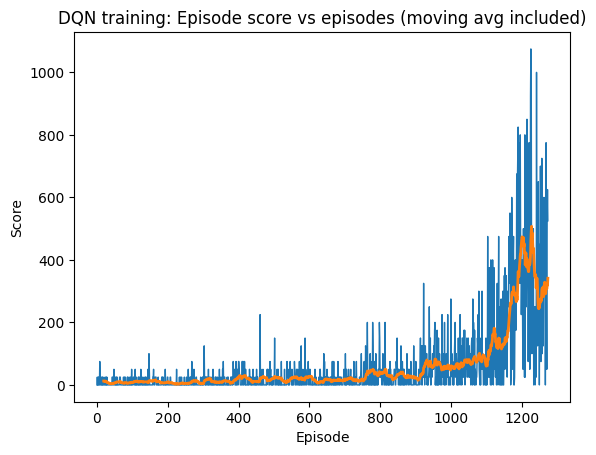

Episodes: 1275 Best score seen: 1075
✅ Saved improved DQN policy to: /content/rl_car_game_web/policy.json
Now refresh the game tab and press T for AI.


In [ ]:
import os, json, random, math
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

OUT_DIR = "/content/rl_car_game_web"
POLICY_PATH = os.path.join(OUT_DIR, "policy.json")

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

# ---------- Env approximating the JS game ----------
class JSLikeLaneEnv:
    def __init__(self, lanes=3, H=1.0):
        self.lanes = lanes
        self.H = H
        self.reset()

    def reset(self):
        self.score = 0
        self.alive = True
        self.speed = 1.0
        self.target_lane = 1
        self.spawn_timer = 0.0
        self.obstacles = []  # each: {lane:int, y:float}
        self.player_y = 0.84 * self.H
        self.t = 0.0
        return self._state()

    def _spawn_obstacle(self):
        lane = random.randrange(self.lanes)
        y = -0.06 * self.H
        self.obstacles.append({"lane": lane, "y": y})

    def _update_speed(self):
        self.speed = 1.0 + min(2.2, self.score / 2500.0)

    def _state(self):
        # 2 nearest obstacles ahead (in front)
        ahead = []
        for ob in self.obstacles:
            dy = self.player_y - ob["y"]
            if dy >= 0:
                ahead.append((dy, ob["lane"]))
        ahead.sort(key=lambda x: x[0])

        if len(ahead) >= 1:
            dy1, l1 = ahead[0]
        else:
            dy1, l1 = (self.H, self.target_lane)

        if len(ahead) >= 2:
            dy2, l2 = ahead[1]
        else:
            dy2, l2 = (self.H, self.target_lane)

        ob1_dist = float(np.clip(dy1 / self.H, 0, 1))
        ob2_dist = float(np.clip(dy2 / self.H, 0, 1))
        speed_norm = float(np.clip((self.speed - 1.0) / 2.2, 0, 1))

        return np.array([self.target_lane, l1, ob1_dist, l2, ob2_dist, speed_norm], dtype=np.float32)

    def step(self, action):  # 0=left, 1=stay, 2=right
        if not self.alive:
            return self._state(), 0.0, True, {}

        prev_lane = self.target_lane
        if action == 0: self.target_lane = max(0, self.target_lane - 1)
        if action == 2: self.target_lane = min(self.lanes - 1, self.target_lane + 1)

        # small penalty for jittery lane switching
        reward = 0.01 - (0.002 if self.target_lane != prev_lane else 0.0)

        # update speed from score (like JS)
        self._update_speed()

        dt = 0.033  # ~30 FPS
        self.t += dt

        # spawn timer logic (JS-like)
        self.spawn_timer -= dt * self.speed
        if self.spawn_timer <= 0:
            self._spawn_obstacle()
            self.spawn_timer = max(0.25, 0.65 - self.score / 6000.0)

        # move obstacles
        fall = self.H * (0.55 * self.speed)
        for ob in self.obstacles:
            ob["y"] += fall * dt

        # remove passed obstacles and add score (and reward)
        kept = []
        for ob in self.obstacles:
            if ob["y"] > self.H:
                self.score += 25
                reward += 0.05
            else:
                kept.append(ob)
        self.obstacles = kept

        # collision check (simple lane-based)
        # treat collision if any obstacle in same lane is "close" to player y
        carH = 0.07 * self.H
        obH  = 0.06 * self.H
        for ob in self.obstacles:
            if ob["lane"] == self.target_lane:
                if abs(ob["y"] - self.player_y) < (carH + obH) * 0.5:
                    self.alive = False
                    reward = -1.0
                    return self._state(), reward, True, {"score": self.score}

        return self._state(), reward, False, {"score": self.score}


# ---------- DQN ----------
class DQN(nn.Module):
    def __init__(self, state_dim=6, hidden=64, action_dim=3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, action_dim)
        )
    def forward(self, x): return self.net(x)

class Replay:
    def __init__(self, cap=100_000):
        self.cap = cap
        self.buf = []
        self.i = 0
    def add(self, s, a, r, s2, d):
        item = (s, a, r, s2, d)
        if len(self.buf) < self.cap:
            self.buf.append(item)
        else:
            self.buf[self.i] = item
            self.i = (self.i + 1) % self.cap
    def sample(self, n):
        batch = random.sample(self.buf, n)
        s,a,r,s2,d = map(np.array, zip(*batch))
        return s.astype(np.float32), a.astype(np.int64), r.astype(np.float32), s2.astype(np.float32), d.astype(np.float32)
    def __len__(self): return len(self.buf)

env = JSLikeLaneEnv()
q = DQN().to(device)
qt = DQN().to(device)
qt.load_state_dict(q.state_dict())
opt = optim.Adam(q.parameters(), lr=1e-3)

rb = Replay()
gamma = 0.99
batch_size = 256
start_learn = 5_000
target_every = 2_000

steps = 120_000
eps_start, eps_end = 1.0, 0.05

episode_scores = []
episode_len = 0
ep_best = -1
s = env.reset()
cur_score_at_reset = 0

def epsilon(t):
    # linear decay
    return eps_end + (eps_start - eps_end) * max(0.0, 1.0 - t / (0.7 * steps))

for t in range(1, steps + 1):
    eps = epsilon(t)
    if random.random() < eps:
        a = random.randrange(3)
    else:
        with torch.no_grad():
            a = int(torch.argmax(q(torch.tensor(s, device=device).unsqueeze(0))).item())

    s2, r, done, info = env.step(a)
    rb.add(s, a, r, s2, float(done))
    s = s2
    episode_len += 1

    if done:
        sc = info.get("score", env.score)
        episode_scores.append(sc)
        ep_best = max(ep_best, sc)
        s = env.reset()
        episode_len = 0

    if len(rb) >= start_learn:
        bs, ba, br, bs2, bd = rb.sample(batch_size)
        bs  = torch.tensor(bs, device=device)
        ba  = torch.tensor(ba, device=device).unsqueeze(1)
        br  = torch.tensor(br, device=device).unsqueeze(1)
        bs2 = torch.tensor(bs2, device=device)
        bd  = torch.tensor(bd, device=device).unsqueeze(1)

        q_sa = q(bs).gather(1, ba)

        with torch.no_grad():
            max_q_next = qt(bs2).max(dim=1, keepdim=True).values
            target = br + gamma * (1.0 - bd) * max_q_next

        loss = nn.functional.smooth_l1_loss(q_sa, target)
        opt.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(q.parameters(), 5.0)
        opt.step()

        if t % target_every == 0:
            qt.load_state_dict(q.state_dict())

# ----- Logging plot -----
if len(episode_scores) > 5:
    window = 20
    ma = np.convolve(episode_scores, np.ones(window)/window, mode="valid")
else:
    ma = []

plt.figure()
plt.plot(episode_scores, linewidth=1)
if len(ma):
    plt.plot(range(window-1, window-1+len(ma)), ma, linewidth=2)
plt.title("DQN training: Episode score vs episodes (moving avg included)")
plt.xlabel("Episode")
plt.ylabel("Score")
plt.show()

print("Episodes:", len(episode_scores), "Best score seen:", ep_best)

# ----- Export policy.json for JS -----
# Export as 2-layer MLP (W1,b1,W2,b2)
with torch.no_grad():
    # layer0: Linear(6->64), layer2: Linear(64->3)
    l0 = q.net[0]
    l2 = q.net[2]
    policy = {
        "type": "mlp",
        "state_dim": 6,
        "W1": l0.weight.detach().cpu().numpy().tolist(),  # [64][6]
        "b1": l0.bias.detach().cpu().numpy().tolist(),    # [64]
        "W2": l2.weight.detach().cpu().numpy().tolist(),  # [3][64]
        "b2": l2.bias.detach().cpu().numpy().tolist()     # [3]
    }

os.makedirs(OUT_DIR, exist_ok=True)
with open(POLICY_PATH, "w", encoding="utf-8") as f:
    json.dump(policy, f)

print("✅ Saved improved DQN policy to:", POLICY_PATH)
print("Now refresh the game tab and press T for AI.")


In [ ]:
import shutil, os

SRC_DIR = "/content/rl_car_game_web"
ZIP_PATH = "/content/lane-car-RLearning.zip"

shutil.make_archive(ZIP_PATH.replace(".zip",""), "zip", SRC_DIR)
print("Created:", ZIP_PATH)


Created: /content/lane-car-RLearning.zip


In [ ]:
import pathlib, re

OUT_DIR = "/content/rl_car_game_web"
index_path = pathlib.Path(f"{OUT_DIR}/index.html")

html = index_path.read_text(encoding="utf-8")

# Add a high-contrast style for the Mode button (mobile-friendly)
style_block = """
<style>
  #modeBtn {
    background: linear-gradient(135deg, #22c55e, #16a34a);
    color: #062e1a;
    border: 1px solid rgba(255,255,255,0.25);
    box-shadow: 0 0 0 1px rgba(0,0,0,0.25) inset;
  }
  #modeBtn:hover {
    filter: brightness(1.05);
  }
  @media (max-width: 768px) {
    #modeBtn {
      background: linear-gradient(135deg, #38bdf8, #2563eb);
      color: #041427;
    }
  }
</style>
"""

# Inject the style block once, right before </head>
if "</head>" in html and "/* mode contrast */" not in html:
    html = html.replace("</head>", style_block + "\n</head>")

index_path.write_text(html, encoding="utf-8")
print("✅ Increased contrast for Mode button (desktop + mobile). Refresh the page.")


✅ Increased contrast for Mode button (desktop + mobile). Refresh the page.


In [ ]:
from google.colab import files
files.download("/content/rl_car_game_web/index.html")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>